**1)Завантажити початкові Дані та репрезентувати їх**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/MyDrive/ISPPR/Fruits_full/Training/"
val_path = "/content/drive/MyDrive/ISPPR/Fruits_full/Validation/"

Mounted at /content/drive


(100, 100, 3)


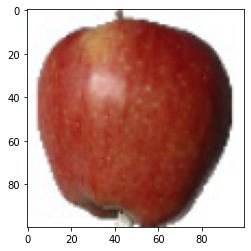

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline


img = mpimg.imread(train_path + 'Apple Red 1/101_100.jpg')
print(img.shape)
plt.imshow(img)

(100, 100, 3)


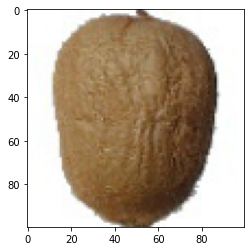

In [3]:
img = mpimg.imread(val_path + 'Kiwi/7_100.jpg')
print(img.shape)
plt.imshow(img)

In [4]:
import os, os.path


train_categories = []
train_samples = []
for i in os.listdir(train_path):
    train_categories.append(i)
    train_samples.append(len(os.listdir(train_path +i)))

test_categories = []
test_samples = []
for i in os.listdir(val_path):
    test_categories.append(i)
    test_samples.append(len(os.listdir(val_path + i)))

    
print("Count of Fruits in Training set:", sum(train_samples))
print("Count of Fruits in Set set:", sum(test_samples))

Count of Fruits in Training set: 15515
Count of Fruits in Set set: 5200


33


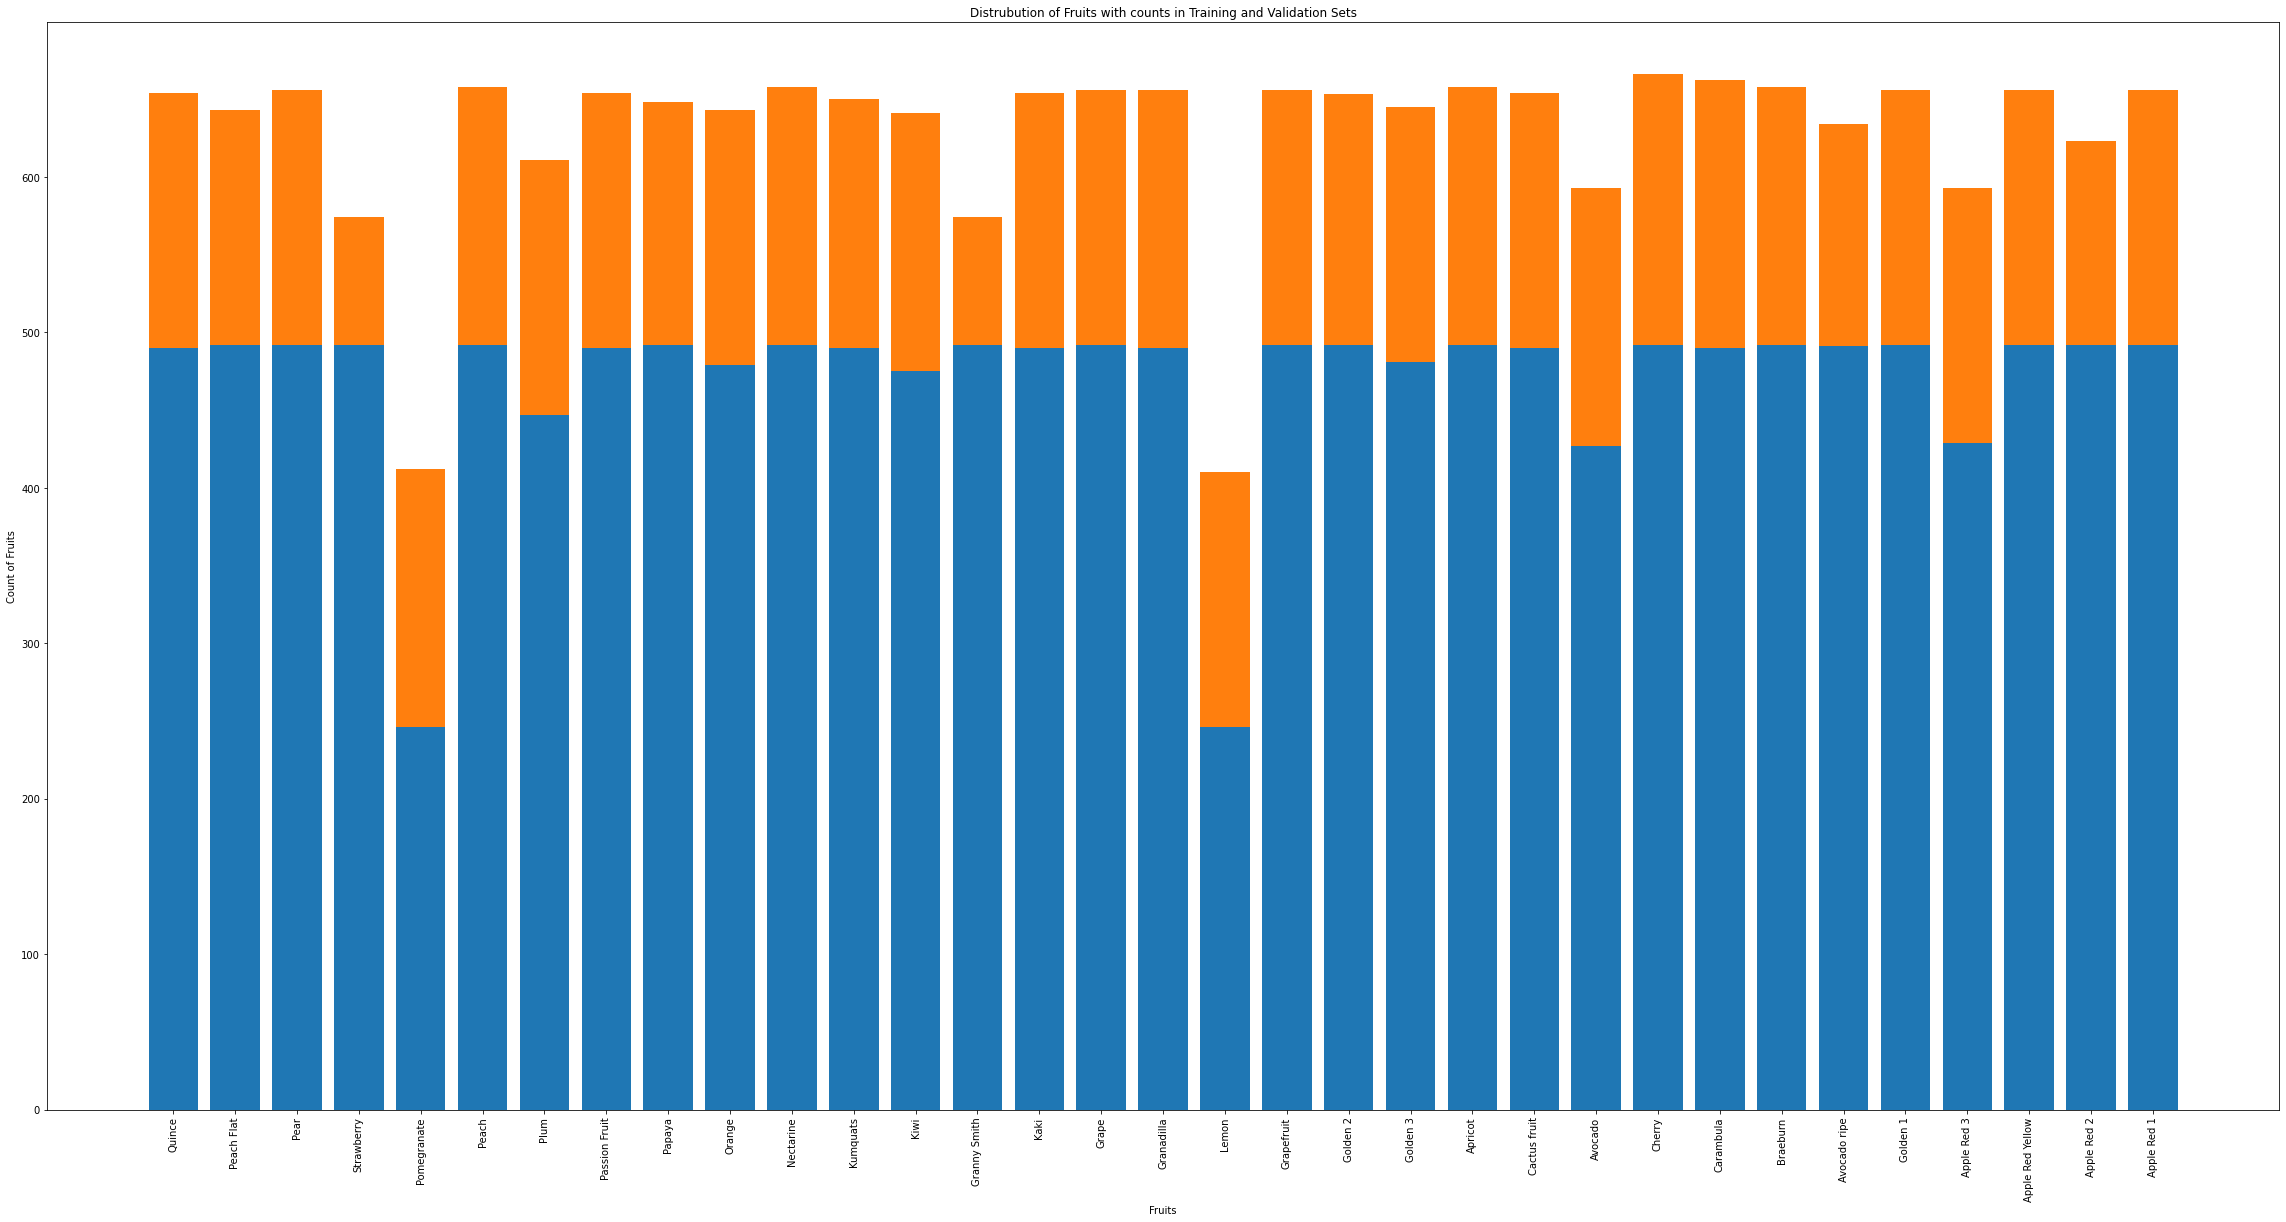

In [5]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams["figure.figsize"] = figure_size
n_classes = len(train_categories)
print(n_classes)
index = np.arange(n_classes)
plt.bar(index, train_samples, label='train')
plt.bar(index, test_samples, label='test', bottom=train_samples)
plt.xlabel('Fruits')
plt.ylabel('Count of Fruits')
plt.xticks(index, train_categories, rotation=90)
plt.title('Distrubution of Fruits with counts in Training and Validation Sets')
plt.show()

In [6]:
from sklearn.datasets import load_files


def load_dataset(data_path):
    data_loading = load_files(data_path)
    files_add = np.array(data_loading['filenames'])
    targets_fruits = np.array(data_loading['target'])
    target_labels_fruits = np.array(data_loading['target_names'])
    return files_add,targets_fruits,target_labels_fruits

x_test_pic, y_test,_ = load_dataset(val_path)
print('test set has been uploaded')
x_train_pic, y_train,target_labels = load_dataset(train_path)
print('train set has been uploaded')


test set has been uploaded


KeyboardInterrupt: ignored

# New Section

In [ ]:
from keras.utils import np_utils
print(y_train[0])
y_train = np_utils.to_categorical(y_train,n_classes)
y_test = np_utils.to_categorical(y_test,n_classes)
y_train[0]



In [ ]:
x_train_pic[0]


In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import tensorflow as tf

def convert_image_to_array_form(files):
    images_array=[]
    for file in files:
        images_array.append(img_to_array(load_img(file)))
    return images_array

x_train_un = np.array(convert_image_to_array_form(x_train_pic))
print('Training set shape : ',x_train_un.shape)

x_test_un = np.array(convert_image_to_array_form(x_test_pic))
print('Test set shape : ',x_test_un.shape)

print('1st training image shape ',x_train_un[0].shape)

In [ ]:
x_train = x_train_un.astype('float32')/255
x_test = x_test_un.astype('float32')/255

In [ ]:

class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Softmax
import tensorflow as tf


def start_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])

In [ ]:
!rm -rf logs

In [ ]:
%reload_ext tensorboard

model = start_model()
metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy'), F1_Score('f1')]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics) 
logdir = os.path.join("logs", 'start')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(600, activation='relu', kernel_initializer=tf.keras.initializers.HeUniform),
    tf.keras.layers.Dense(30, activation='relu',  kernel_initializer=tf.keras.initializers.HeUniform),
    tf.keras.layers.Dense(4, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics) 

logdir = os.path.join("logs", 'model_RELU_only1')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model1.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(600, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform),
    tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform),
    tf.keras.layers.Dense(4, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=metrics) 

logdir = os.path.join("logs", 'model_Tanh_only')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model2.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

In [ ]:
model_with_DO = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(600, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform),
    tf.keras.layers.Dense(4, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=metrics) 

logdir = os.path.join("logs", 'model_Tanh_only_with_Dropout')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model2.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs

**2) Представити Дані графічно**
Значення цільової зміної в залежності від Х

In [ ]:
predictions = model.predict(x_test)
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(predictions[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
